In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import scipy.stats as sts

In [3]:
df = pd.read_csv('/Users/anastasiahimic/Desktop/hse_python_project_3/part_1/data_ab.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

Первым временем привели время к нужному формату

In [7]:
df['user_id'].nunique(), len(df)

(290584, 294478)

в данных есть дубликаты



In [8]:
(df['user_id'].value_counts() > 2).sum()

np.int64(0)

Нет людей которые в данных 3 или больше раз, все дубликаты по 2. тогда всего лишник строк 3894 в каждой из них дублкат для юзеров. то есть у 3894 человек есть "двойник". сохраним дубликаты в табличчку, чтобы проанализировать

In [9]:

dupl_mask = df.duplicated(subset=['user_id'], keep=False) #дубликаты по айди
x = np.arange(0, 7788)
dupl_df = df[dupl_mask].copy().reset_index(drop = True) #дальше работа с номерами поэтому нужно сбросит ьиндексы
dupl_df = dupl_df.sort_values(['user_id', 'timestamp'], ascending= [False, True]) #сортировка чтобы сначала было первое вхождение юзера а потом второе
dupl_df.head(20)
dupl_f = dupl_df[x%2 == 0].reset_index(drop = True) #первые вхождения
dypl_s = dupl_df[x%2 == 1].reset_index(drop = True) #вторые вхождения

Text(0, 0.5, 'Количество')

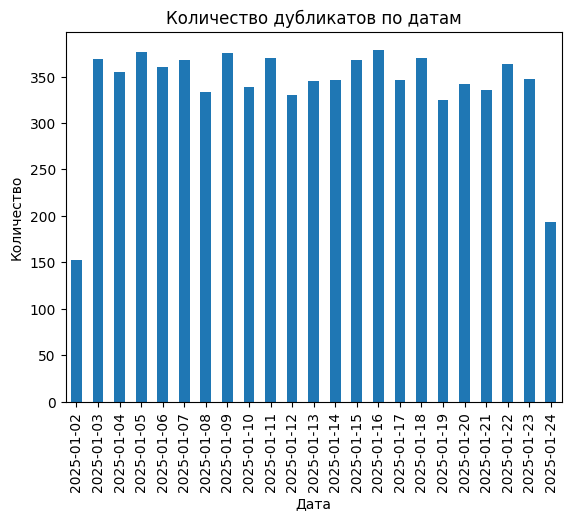

In [10]:
dupl_df['date'] = dupl_df['timestamp'].dt.date #забрали значение даты
date_counts = dupl_df['date'].value_counts().sort_index() #посчитали сколько раз встречаются даты и отсортировали для графика

date_counts.plot(kind='bar')
plt.title('Количество дубликатов по датам')
plt.xlabel('Дата')
plt.ylabel('Количество')



0


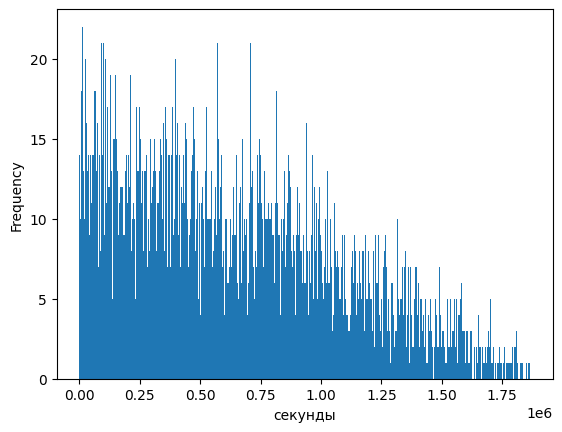

In [11]:
time_diff = (dypl_s['timestamp'] - dupl_f['timestamp']).dt.total_seconds() # посчитали время между дубликатами

time_diff.plot(kind = 'hist', xlabel = 'cекунды', bins = 500)

print((time_diff < 300).sum())

In [12]:
gr_match_musk = (dupl_f['group'] == dypl_s['group']) #у скольких дубликатов отличаются группы
lend_march_musk = (dupl_f['landing_page'] == dypl_s['landing_page']) # у скольких дубликатов отличаются страницы
print((gr_match_musk & lend_march_musk).sum()) # выведем кол-во во всех комбинациях
print((gr_match_musk & (~lend_march_musk)).sum())
print(((~gr_match_musk) & (~lend_march_musk)).sum())
print(((~gr_match_musk) & (lend_march_musk)).sum())


1
1998
0
1895


In [13]:
corr11_mask = ((dupl_f['converted'] == 1) & (dypl_s['converted']== 1)) # посчитаем как менялся покатель конвертацию у пользователей с двумя включениями
corr10_mask = ((dupl_f['converted'] == 1) & (dypl_s['converted']== 0))
corr01_mask = ((dupl_f['converted'] == 0) & (dypl_s['converted']== 1))
corr00_mask = ((dupl_f['converted'] == 0) & (dypl_s['converted']== 0))
print(corr11_mask.sum())
print(corr10_mask.sum())
print(corr01_mask.sum())
print(corr00_mask.sum())
corr = dupl_f['converted'].reset_index(drop=True).corr(dypl_s['converted'].reset_index(drop=True))
print(corr)

64
452
412
2966
0.002137756924171232


<Axes: >

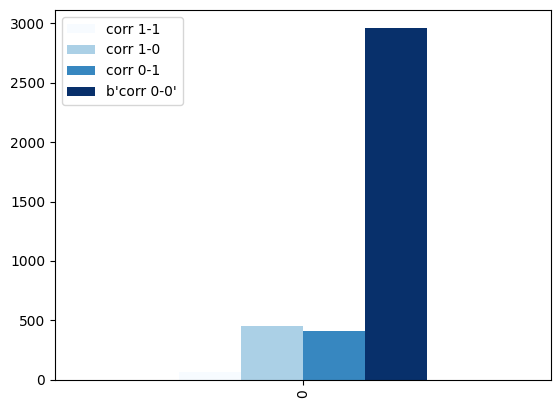

In [14]:
dfvis = pd.DataFrame({ 'corr 1-1': [64],'corr 1-0': [452],'corr 0-1': [412],b'corr 0-0': [2966],})
dfvis.plot(kind = 'bar', colormap= 'Blues')

In [15]:
df.groupby(['group', 'landing_page'])['converted'].agg(['mean', 'count'])

mean   count
group     landing_page                  
control   new_page      0.121369    1928
          old_page      0.120386  145274
treatment new_page      0.118807  145311
          old_page      0.127226    1965

В данных есть ситуации, когда пользователи видели не ту версию сайта, такие данные нельзя использовать в A/Б тесте

In [16]:
dubl = df.duplicated(subset=['user_id'], keep=False)
df[dubl].groupby(['group', 'landing_page'])['converted'].agg(['mean', 'count'])

mean  count
group     landing_page                 
control   new_page      0.121369   1928
          old_page      0.135790   1981
treatment new_page      0.124869   1914
          old_page      0.127226   1965

Общие выводы по дублкатам:

1)так как время между дубликатами весьма велико это не перезагрузка страницы сброс сеанса или что-то такое \
2) ошибки в несоответствии групп и лендинга встречаются и в первых заходах так и во вторых это не исправление системы на нужный лендинг\
3) все дубликаты это исключительно пары\
4) у всех дубликатов (кроме 1) отличается группа но одинаковый лендинг или наоброт\
5) если грубо взять среднюю конверсию за 0.124 то выходит что 64 дубликата у которых 1 - 1 это очень близко к 3984*0.124^2 аналогично для других ситуаций 1-0
0-1
0-0
(также отдельно вывели корреляцию и её значение крайне бликзо к 0)
конверсия у дубликатов ведёт себя так как будто конверсия у дубликата в первом заходе и во втором независимы, что явлеется очень странным фактом, так как это один и тот же человек.

6) дубликаты распределены по дням равномерно, это не сбой в начале/конце експеремента

###гипотеза
дубликаты это разные пользователи, которым система по ошибки присвоила один юзер нейм, это объясняет тот факт что конверсия у дубликатов ведёт себя так, буд-то она независима. а так-же в таблице нет дубликатов у которых потворяется и лендинг и группа, видимо система прроверяла индентичность по этим 3 колонкам. то есть ошибка возникала у юзеров которым присвоили одинаковый юзер нейм, но при этом они в разных группах/лендингов.
Однако мы не уверены в этом на сто процентов поэтому надёжным решением будет удалить дубликаты которые повторны по времени, чтобы обеспечить максимальную чистоту данных, также мы удалим и те первичные появления, в которых не мэтчится группа и лендинг. так мы обезапасим данные максимально надёжно



Заметим что все несовпадения связаны с дубликатами, для начала удалим дубликаты которые встретились позже (пользователь видел другую версию, и условия эксперементы нарушены).

In [17]:
df_sorted = df.sort_values('timestamp') # отсортили по времени
clean_df = df_sorted.drop_duplicates(subset=['user_id'], keep='first') #удалили вторые включения
clean_df = clean_df.reset_index(drop=True)

In [18]:
clean_df.groupby(['group', 'landing_page'])['converted'].agg(['mean', 'count'])

mean   count
group     landing_page                  
control   new_page      0.124103     975
          old_page      0.120393  144319
treatment new_page      0.118698  144316
          old_page      0.138604     974

значит ошибки были не только у повторных заходов, удалим оставшиеся ошибки

In [19]:
correct = (
    (clean_df['group'] == 'control') & (clean_df['landing_page'] == 'old_page')
) | (
    (clean_df['group'] == 'treatment') & (clean_df['landing_page'] == 'new_page')
)
clean_df = clean_df[correct] #удалили то что не метчилось

In [20]:
clean_df.groupby(['group', 'landing_page'])['converted'].agg(['mean', 'count'])

,,mean,count
group,landing_page,,
control,old_page,0.120393,144319
treatment,new_page,0.118698,144316


In [21]:
(clean_df['user_id'].value_counts() > 1).sum()

np.int64(0)

EDA закончено

,user_id,timestamp,group,landing_page,converted,huor
0,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,13
1,781507,2025-01-02 13:42:15.234051,control,old_page,0,13
2,737319,2025-01-02 13:42:21.786186,control,old_page,0,13
3,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,13
4,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,13
...,...,...,...,...,...,...
290579,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,13
290580,808330,2025-01-24 13:41:19.152664,control,old_page,0,13
290581,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,13
290582,836373,2025-01-24 13:41:52.604673,control,old_page,0,13


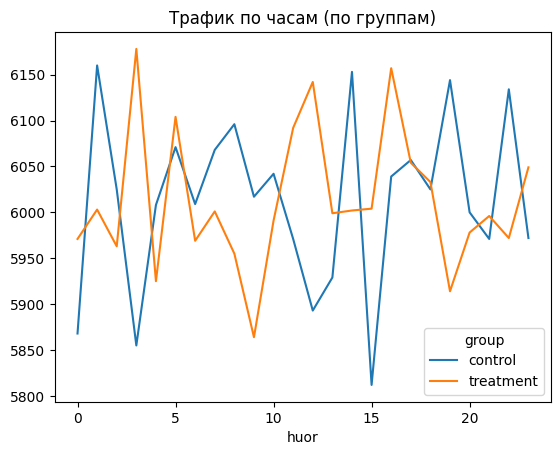

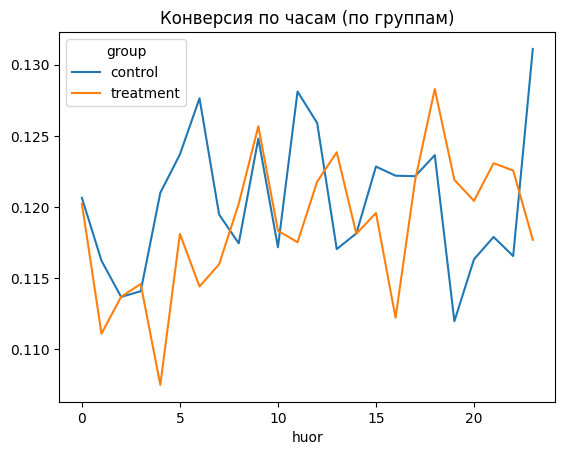

In [22]:
clean_df['huor'] = clean_df['timestamp'].dt.hour #выделили часы
clean_df.groupby(['huor', 'group'])['user_id'].count().unstack().plot( title='Трафик по часам (по группам)') #сделали табличку с индексами часами и двумя столбиками, для каждого будет график
clean_df.groupby(['huor', 'group'])['converted'].mean().unstack().plot( title='Конверсия по часам (по группам)') # принцип тот же но считаем другое
clean_df



In [23]:
clean_df.groupby(['huor', 'group'])['user_id'].count().unstack().describe() #узнаем параметры

group,control,treatment
count,24.000000,24.000000
mean,6013.291667,6013.166667
std,94.018721,76.933436
min,5812.000000,5864.000000
25%,5971.000000,5970.500000
50%,6021.000000,6000.000000
75%,6068.750000,6050.250000
max,6160.000000,6178.000000


анализ показов по часам: Отношение стд к среднему очень мало разбивать на когорты по часам с целью уменьшить дисперсию бессмыслено

In [24]:
clean_df.groupby(['huor', 'group'])['converted'].mean().unstack().describe() #узнаем параметры

group,control,treatment
count,24.000000,24.000000
mean,0.120415,0.118708
std,0.004924,0.004825
min,0.111979,0.107511
25%,0.116930,0.115636
50%,0.120067,0.118966
75%,0.123664,0.121906
max,0.131112,0.128294


Анализ конверсии по часам: отношение стд  к среднему очень мало, разбивать на когорты не имеет смысла

<Axes: title={'center': 'Конверсия по датам (по группам)'}, xlabel='date'>

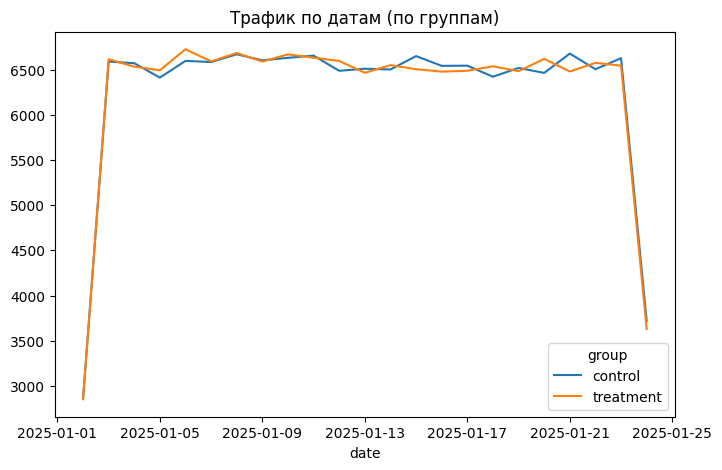

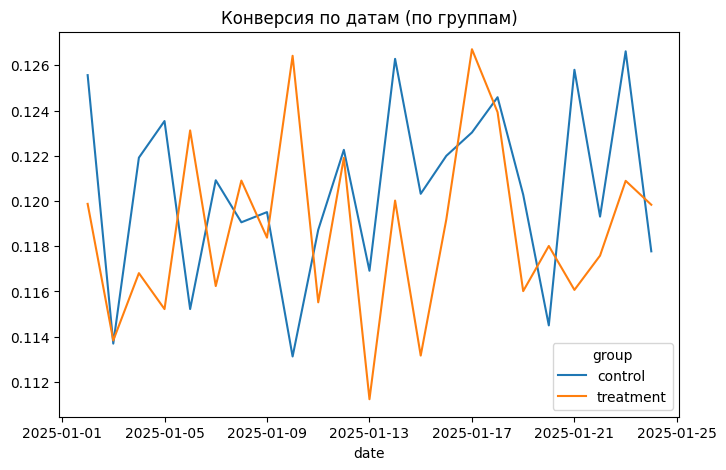

In [25]:
clean_df['date'] = clean_df['timestamp'].dt.date
clean_df.groupby(['date', 'group'])['user_id'].count().unstack().plot(figsize=(8,5), title='Трафик по датам (по группам)') #тут всё похоже но даты а не часы
clean_df.groupby(['date', 'group'])['converted'].mean().unstack().plot(figsize=(8,5), title='Конверсия по датам (по группам)') #аналогично

In [26]:
clean_df.groupby(['date', 'group'])['user_id'].count().unstack().describe()

group,control,treatment
count,23.000000,23.000000
mean,6274.739130,6274.608696
std,953.967324,966.851955
min,2859.000000,2853.000000
25%,6493.500000,6484.500000
50%,6543.000000,6543.000000
75%,6614.000000,6605.000000
max,6677.000000,6725.000000


In [27]:
clean_df.groupby(['date', 'group'])['converted'].mean().unstack().describe()

group,control,treatment
count,23.000000,23.000000
mean,0.120477,0.118734
std,0.004031,0.004008
min,0.113122,0.111231
25%,0.118250,0.116040
50%,0.120319,0.118379
75%,0.123285,0.120898
max,0.126622,0.126715


анализ по датам: хоть тут уже стандартное отколонения показов состовляет больше 10 процентов от среднего стоит помнить что это просто показы, а вот стандартное отклоение конверсии сохраняется очень маленьким по отношению к среднему, то есть по датам на когорты разбивать тоже смысла нет.

In [28]:
clean_df.shape

(288635, 7)

После очистки данных мы получили 288 635 корректных наблюдений, в которых каждый пользователь относится ровно к одной группе и видел только соответствующую ей версию лендинга. Полностью устранены случаи неправильного назначения страницы и появления пользователей в двух группах. Датасет приобрёл строгую структуру “1 пользователь = 1 наблюдение”, необходимую для корректного статистического анализа. Средняя конверсия в очищенном датасете составляет 11.94%.

In [29]:
clean_df['group'].value_counts(normalize=True)

group
control      0.500005
treatment    0.499995
Name: proportion, dtype: float64

 Первичный анализ показал, что распределение по группам сбалансировано, отношение стандартного отклонения к среднемму конверсий по датам и часам очень мало. показы по датам и часам распределены равномерно, выборки одинакового размера (разница меньше процента). разбиение на когорты или другуя спецефическая подготовка данных перед тестом не требуется

выявили минимальное раздичие в соотношение в группах

In [30]:
clean_df.groupby('group')['converted'].mean()

group
control      0.120393
treatment    0.118698
Name: converted, dtype: float64

сравнили конверсию по группам. это центральная метрика эксперемента, она не сильно отличается, причём средний показатель по ней в новой группе немного хуже

**ПОСТРОЕНИЕ ГИПОТЕЗ**

**Нулевая гипотеза H0**:
Конверсия на новой странице (treatment) не отличается от конверсии на старой странице (control).

**Альтернативная гипотеза H1**:
Конверсия в treatment отличается от control

# Выбор теста
Данные категориальны (конверсия либо да либо нет)
множество испытаний бернули -> биноминальное распределение
испытаний оченнь много, можно сказать что генеральная совокупность распределена нормально, для таких данные используем Z - тест. конкретно в нашем случае, анализ двух пропорций

In [31]:
control = clean_df[clean_df['group'] == 'control']
control_conv = control['converted'].mean()
print(round(control_conv, 4))
treatment = clean_df[clean_df['group'] == 'treatment']
treatment_conv = treatment['converted'].mean()
print(round(treatment_conv, 4))

count = [treatment['converted'].sum(), control['converted'].sum()]
nobs = [len(treatment), len(control)]
z_stat, p_value = proportions_ztest(count, nobs)
print(z_stat)
print(p_value)

0.1204
0.1187
-1.4035742794239752
0.16044565865244187


На очищенных данных была проведена проверка гипотезы о равенстве конверсий в контрольной (old_page) и тестовой (new_page) группах.
Конверсия в control составила 0.1202, в treatment — 0.1187. Разница составляет –0.0015 (–0.15 п.п.).
Z-тест для двух пропорций показал отсутствие статистически значимого эффекта: z = –1.20, p = 0.232 > 0.05.
Таким образом, мы не можем отвергнуть нулевую гипотезу, и считаем, что новая версия страницы не оказала значимого влияния на конверсию.

Трафик в обе группы распределялся равномерно и однородно на протяжении всего периода эксперимента.
Конверсия в обеих группах ведёт себя одинаково во времени.

Нет временных скачков, трендов или аномалий, которые могли бы объяснить различия вне влияния тестируемого изменения.

Бутстрап

Control conversion: 0.12039917935897611
Treatment conversion: 0.11891957956489856
95% Доверительный интервал: -0.0037951636536973183 0.0008225977986767403


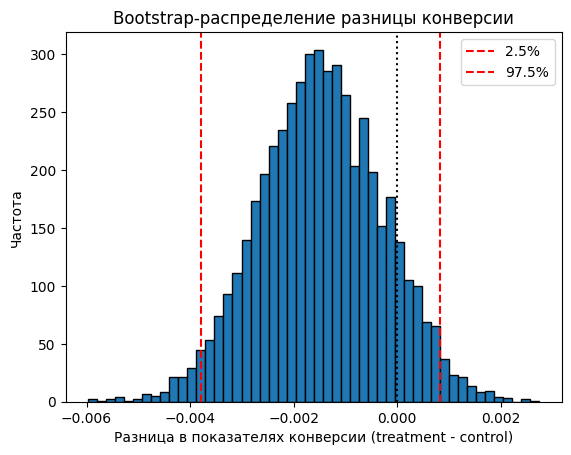

In [32]:


control = df[df["group"] == "control"]["converted"].values  #фильтрует масиив, что бы была группа control и значания конверсии(0или1), .values - делает нампай массив
treatment = df[df["group"] == "treatment"]["converted"].values # аналагично с treatment

print("Control conversion:", np.mean(control)) #вывод среднего значения
print("Treatment conversion:", np.mean(treatment))

# Параметры бутстрапа
n_boot = 5000 #кол-во взятий ресемпла и пересчёта разницы конверсий
n_c = len(control) # число наблюдейний в группе
n_t = len(treatment)

boot_diffs = [] # В него будут записываться значения разницы конверсий (cr_t - cr_c)
                # для каждой бутстрап‑итерации, чтобы потом анализировать их распределение и считать доверительный интервал.


for _ in range(n_boot):
    sample_c = np.random.choice(control, size=n_c, replace=True) # рандомно создаётся выборка из control группы, n_c элементов, с возможностью повторов
    sample_t = np.random.choice(treatment, size=n_t, replace=True)

    cr_c = sample_c.mean() #средняя конверсия для 1 из групп в бутстраппе
    cr_t = sample_t.mean()
    boot_diffs.append(cr_t - cr_c) #вычисляем разницу конверсий текущих выборок и добавляем в boot_diffs.
                                   #5000 таких оценок дадут эмперическое (не поддающееся формулам) распределение

boot_diffs = np.array(boot_diffs) #делаем нампай массив для расчета ДИ и статистики

# 95% Доверительный интервал (ДИ)
ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5]) # Считает 2.5‑й и 97.5‑й процентили распределения boot_diffs
print("95% Доверительный интервал:", ci_low, ci_high)

# Гистограмма распределения
plt.hist(boot_diffs, bins=50, edgecolor="black")
plt.axvline(ci_low, color="red", linestyle="--", label="2.5%")
plt.axvline(ci_high, color="red", linestyle="--", label="97.5%")
plt.axvline(0, color="black", linestyle=":")
plt.xlabel("Разница в показателях конверсии (treatment - control)")
plt.ylabel("Частота")
plt.legend()
plt.title("Bootstrap-распределение разницы конверсии")
plt.show()


Мы использовали бутстрап для оценки неопределённости разницы конверсий.
На основе 5000 бутстрап-репликаций 95% доверительный интервал составил
[-0.0038, 0.0009], что включает 0.
Это означает, что статистически значимого эффекта от новой версии страницы не обнаружено.